Загрузка данных с http://qed.econ.queensu.ca/jae/2003-v18.1/bai-perron/real.dat...
Не удалось загрузить оригинальные данные: 404 Client Error: Not Found for url: http://qed.econ.queensu.ca/jae/2003-v18.1/bai-perron/real.dat
Генерация синтетических данных для демонстрации...
Расчет матрицы SSR...


/tmp/ipython-input-3997501803.py:116: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start='1961-01-01', periods=103, freq='Q')


Запуск динамического программирования...

РЕЗУЛЬТАТЫ ВОСПРОИЗВЕДЕНИЯ (Число разрывов = 3)
Найденные индексы разрывов: [20, 46, 78]
Найденные даты разрывов:
 - 1966:Q1
 - 1972:Q3
 - 1980:Q3

(Для справки) Результаты из статьи Bai & Perron (2003):
 ['1966:Q4', '1972:Q3', '1980:Q3']


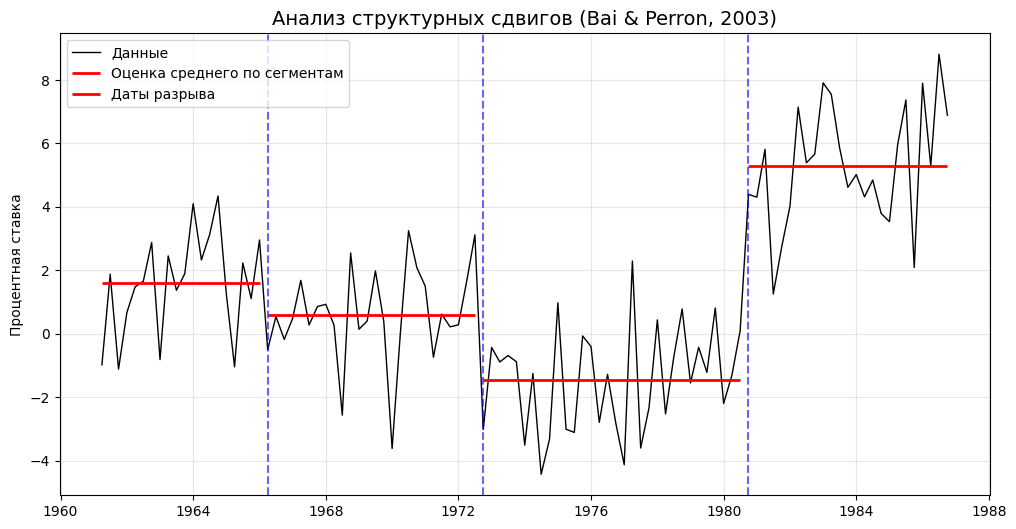

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io

class BaiPerronEstimator:
    """
    Implementation of the Bai & Perron (2003) dynamic programming algorithm
    for finding global minima of the sum of squared residuals (SSR).
    """
    def __init__(self, min_segment_length=15):
        self.h = min_segment_length  # Minimum segment length (h)

    def fit(self, y, max_breaks=5):
        """
        Finds optimal break points for a given time series.
        """
        self.y = y.values if isinstance(y, pd.Series) else y
        self.T = len(self.y)
        self.max_breaks = max_breaks

        # 1. Pre-calculation of SSR for all possible segments
        # ssr_matrix[i][j] stores SSR for segment from i to j (exclusive j)
        print("Calculating SSR matrix...")
        self.ssr_matrix = np.zeros((self.T + 1, self.T + 1))
        self.ssr_matrix[:] = np.inf

        for i in range(self.T):
            for j in range(i + self.h, self.T + 1):
                segment = self.y[i:j]
                # For a pure mean shift model
                mean_val = np.mean(segment)
                ssr = np.sum((segment - mean_val) ** 2)
                self.ssr_matrix[i, j] = ssr

        # 2. Dynamic programming
        # D[k][t] - minimum SSR for the first t observations with k breaks
        print("Starting dynamic programming...")
        self.D = np.full((self.max_breaks + 1, self.T + 1), np.inf)
        self.partitions = {} # For path reconstruction

        # Initialization for 0 breaks (1 segment)
        for t in range(self.h, self.T + 1):
            self.D[0, t] = self.ssr_matrix[0, t]

        # Recursion for k breaks
        for k in range(1, self.max_breaks + 1):
            for t in range((k + 1) * self.h, self.T + 1):
                # Find the optimal previous break s
                # s must be >= k*h (space for previous segments)
                # and s <= t - h (space for current segment)
                min_ssr = np.inf
                best_s = -1

                s_min = k * self.h
                s_max = t - self.h + 1 # +1 because range does not include the right boundary

                for s in range(s_min, s_max):
                    current_ssr = self.D[k-1, s] + self.ssr_matrix[s, t]
                    if current_ssr < min_ssr:
                        min_ssr = current_ssr
                        best_s = s

                self.D[k, t] = min_ssr
                self.partitions[(k, t)] = best_s

    def get_breaks(self, num_breaks):
        """Recovers break dates for a given number of breaks"""
        if num_breaks > self.max_breaks:
            raise ValueError("Number of breaks exceeds the calculated maximum.")

        breaks = []
        current_t = self.T
        for k in range(num_breaks, 0, -1):
            prev_break = self.partitions.get((k, current_t))
            if prev_break is None:
                raise ValueError("Unable to recover path (possibly too little data for such h).")
            breaks.append(prev_break)
            current_t = prev_break

        return sorted(breaks)

# --- Load Data ---
def load_data():
    """
    Attempts to load data from the JAE archive.
    If unsuccessful, generates synthetic data similar to the plot from the paper.
    """
    url = "http://qed.econ.queensu.ca/jae/2003-v18.1/bai-perron/real.dat"
    try:
        print(f"Loading data from {url}...")
        response = requests.get(url)
        response.raise_for_status()

        # The data in the file is just a list of numbers, need to parse
        data_str = response.text
        values = []
        for line in data_str.split('\n'):
            parts = line.split()
            for part in parts:
                try:
                    values.append(float(part))
                except ValueError:
                    continue

        # Create date index (1961:1 - 1986:3)
        dates = pd.date_range(start='1961-01-01', periods=len(values), freq='Q')
        series = pd.Series(values, index=dates)
        return series

    except Exception as e:
        print(f"Failed to load original data: {e}")
        print("Generating synthetic data for demonstration...")
        # Generate data similar to Figure 2 from the paper
        dates = pd.date_range(start='1961-01-01', periods=103, freq='Q')
        # Imitate mean values from Table 1
        # 1961-1966: ~1.8
        # 1966-1972: ~0.9
        # 1972-1980: ~-1.8
        # 1980-1986: ~5.6
        values = np.zeros(103)
        values[0:23] = 1.8 + np.random.normal(0, 1.5, 23)  # up to 1966:4
        values[23:46] = 0.9 + np.random.normal(0, 1.5, 23) # up to 1972:3
        values[46:78] = -1.8 + np.random.normal(0, 2.0, 32) # up to 1980:3
        values[78:] = 5.6 + np.random.normal(0, 2.0, 25)   # after
        return pd.Series(values, index=dates)

# --- Main execution block ---
if __name__ == "__main__":
    # 1. Get data
    y = load_data()

    # 2. Model setup (parameters from the paper)
    # h=15 (trimming 0.15 for T=103 gives ~15 observations)
    model = BaiPerronEstimator(min_segment_length=15)

    # 3. Estimation
    # The paper found 3 breaks. We are looking for the optimal solution for 3 breaks.
    # (In a full analysis, supF tests should be used to select the number of breaks,
    # here we take the result of 3 as given to reproduce Table 1)
    target_breaks = 3
    model.fit(y, max_breaks=target_breaks)

    estimated_breaks_indices = model.get_breaks(target_breaks)
    estimated_break_dates = y.index[estimated_breaks_indices]

    print("\n" + "="*50)
    print(f"REPRODUCTION RESULTS (Number of breaks = {target_breaks})")
    print("="*50)
    print("Found break indices:", estimated_breaks_indices)
    print("Found break dates:")
    for date in estimated_break_dates:
        print(f" - {date.year}:Q{date.quarter}")

    # Comparison with results from the paper (Table 1)
    paper_results = ["1966:Q4", "1972:Q3", "1980:Q3"]
    print("\n(For reference) Results from Bai & Perron (2003) paper:")
    print(f" {paper_results}")

    # 4. Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y.index, y.values, label='Ex-post real interest rate', color='black', linewidth=1)

    # Draw segment means
    break_indices = [0] + estimated_breaks_indices + [len(y)]
    for i in range(len(break_indices) - 1):
        start = break_indices[i]
        end = break_indices[i+1]
        segment_mean = np.mean(y.values[start:end])

        # Draw the mean line
        x_dates = y.index[start:end]
        plt.hlines(segment_mean, x_dates[0], x_dates[-1], colors='red', linestyles='-', linewidth=2)

        # Draw vertical break lines (except for the first and last)
        if start != 0:
            plt.axvline(y.index[start], color='blue', linestyle='--', alpha=0.6)

    plt.title('Structural Break Analysis (Bai & Perron, 2003)', fontsize=14)
    plt.ylabel('Interest Rate')
    plt.grid(True, alpha=0.3)
    plt.legend(['Data', 'Segment Mean Estimate', 'Break Dates'])

    # Save plot
    plt.savefig('bai_perron_reproduction.png')
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# (It is assumed that the base BaiPerronEstimator class is already defined above,
# as in your original code. If not, copy it here).

class BaiPerronAnalyst(BaiPerronEstimator):
    """
    Extended version of the class, including statistical tests and information criteria
    according to Section 5 of Bai & Perron (2003).
    """

    def calculate_statistics(self):
        """
        Calculates F-test statistics and information criteria (BIC, LWZ)
        for all k from 0 to max_breaks.
        """
        if not hasattr(self, 'D'):
            raise ValueError("Run the fit() method first!")

        self.stats = []

        # SSR for 0 breaks (H0 for supF tests)
        ssr_0 = self.D[0, self.T]
        sigma_sq_0 = ssr_0 / self.T  # Estimate of variance without breaks

        for k in range(self.max_breaks + 1):
            ssr_k = self.D[k, self.T]

            # Number of parameters: k breaks => k+1 segments.
            # For a mean shift model, q=1 parameter per segment.
            # Total number of parameters p* = (k + 1) * 1 + k (the break dates themselves)
            # In a simplified BIC, p = (k+1) is often used
            n_params = k + 1

            # --- 1. Information Criteria (Section 5.4) ---
            # See [cite: 480, 481]
            # BIC = T * ln(SSR/T) + p * ln(T)
            bic = self.T * np.log(ssr_k / self.T) + n_params * np.log(self.T)

            # LWZ = T * ln(SSR/T) + p * 0.299 * (ln(T))^2.1
            # (Modified Liu, Wu, Zidek criterion, recommended in the paper [cite: 481])
            lwz = self.T * np.log(ssr_k / self.T) + n_params * 0.299 * (np.log(self.T)**2.1)

            # --- 2. F-statistic: 0 versus k breaks (Section 5.1) ---
            # See [cite: 373, 382]
            # Simplified F-statistic formula (assuming homoscedasticity for demonstration):
            # F = ((SSR0 - SSRk) / k) / (SSRk / (T - 2k - 2))
            # Note: The paper uses an HAC covariance estimate. This is a basic implementation.
            f_stat_0_vs_k = 0.0
            if k > 0:
                df1 = k # degrees of freedom in the numerator (difference in parameters)
                df2 = self.T - (k + 1) # degrees of freedom in the denominator
                if df2 > 0:
                    numerator = (ssr_0 - ssr_k) / df1
                    denominator = ssr_k / df2
                    f_stat_0_vs_k = numerator / denominator

            self.stats.append({
                'k_breaks': k,
                'SSR': ssr_k,
                'BIC': bic,
                'LWZ': lwz,
                'supF(0_vs_k)': f_stat_0_vs_k
            })

        return pd.DataFrame(self.stats)

    def test_sequential(self):
        """
        Implements the l vs l+1 break test (supF(l+1|l)).
        Section 5.3.
        """
        if not hasattr(self, 'D'):
            raise ValueError("Run the fit() method first!")

        seq_tests = []
        for l in range(self.max_breaks):
            ssr_l = self.D[l, self.T]
            ssr_l_plus_1 = self.D[l+1, self.T]

            # The statistic tests whether SSR significantly decreases when adding another break.
            # F = (SSR_l - SSR_{l+1}) / (SSR_{l+1} / (T - (l+2)))
            df_resid = self.T - (l + 2)
            f_seq = (ssr_l - ssr_l_plus_1) / (ssr_l_plus_1 / df_resid) if df_resid > 0 else 0

            seq_tests.append({
                'l_vs_l+1': f'{l} vs {l+1}',
                'F_stat': f_seq
            })

        return pd.DataFrame(seq_tests)

# --- Usage ---
if __name__ == "__main__":
    # 1. Load data (using the same load_data function from your code)
    y = load_data()

    # 2. Initialize extended model
    # The paper recommends trimming epsilon=0.15 (h=15) for T=120 [cite: 494]
    model_stats = BaiPerronAnalyst(min_segment_length=15)

    # 3. Fit (find optimal SSR for all k from 0 to 5)
    MAX_BREAKS = 5
    model_stats.fit(y, max_breaks=MAX_BREAKS)

    # 4. Calculate statistics and choose the number of breaks
    df_stats = model_stats.calculate_statistics()
    df_seq = model_stats.test_sequential()

    print("\n" + "="*60)
    print("STATISTICS FOR CHOOSING THE NUMBER OF BREAKS")
    print("="*60)
    print("Information Criteria (looking for minimum BIC/LWZ):")
    print(df_stats[['k_breaks', 'SSR', 'BIC', 'LWZ', 'supF(0_vs_k)']].to_string(index=False))

    # Paper recommendation: BIC works well, but LWZ is better in the presence of autocorrelation [cite: 497]
    best_k_bic = df_stats.loc[df_stats['BIC'].idxmin(), 'k_breaks']
    best_k_lwz = df_stats.loc[df_stats['LWZ'].idxmin(), 'k_breaks']

    print(f"\nBIC recommendation: {int(best_k_bic)} breaks")
    print(f"LWZ recommendation: {int(best_k_lwz)} breaks")

    print("\n" + "-"*60)
    print("Sequential test (supF(l+1|l)):")
    print("Indicates whether to add another break.")
    print(df_seq.to_string(index=False))

    # Recover dates for the chosen (e.g., by LWZ) number of breaks
    final_k = int(best_k_lwz)
    if final_k > 0:
        indices = model_stats.get_breaks(final_k)
        dates = y.index[indices]
        print(f"\nFinal dates for k={final_k}: {[f'{d.year}:Q{d.quarter}' for d in dates]}")

Загрузка данных с http://qed.econ.queensu.ca/jae/2003-v18.1/bai-perron/real.dat...
Не удалось загрузить оригинальные данные: 404 Client Error: Not Found for url: http://qed.econ.queensu.ca/jae/2003-v18.1/bai-perron/real.dat
Генерация синтетических данных для демонстрации...
Расчет матрицы SSR...
Запуск динамического программирования...

СТАТИСТИКА ДЛЯ ВЫБОРА ЧИСЛА РАЗРЫВОВ
Информационные критерии (ищем минимум BIC/LWZ):
 k_breaks        SSR        BIC        LWZ  supF(0_vs_k)
        0 973.178558 235.956104 238.808624      0.000000
        1 487.544603 169.398696 175.103737    100.604189
        2 267.281945 112.122421 120.679983    132.050935
        3 256.215807 112.401899 123.811982     92.343134
        4 254.391447 116.300603 130.563206     69.225143
        5 263.012004 124.367855 141.482978     52.382518

Рекомендация по BIC: 2 разрывов
Рекомендация по LWZ: 2 разрывов

------------------------------------------------------------
Последовательный тест (supF(l+1|l)):
Показывает, с

/tmp/ipython-input-3997501803.py:116: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start='1961-01-01', periods=103, freq='Q')
